<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/policy_iteration_reward_fix/Policy_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

##Policy Iteration
Policy iteration is an algorithm for evaluating the value function and improving it in successive iterations. Each iteration involves 2 steps - first step evaluates the policy and the second improves it. The first step is the same as the iterative policy evaluation algorithm and second step is the iteration policy improvement algorithm. Refer to the [Grid World notebook](https://github.com/chandrusuresh/ReinforcementLearning/blob/master/GridWorld.ipynb) for more details on these two steps/algorithms.

The state and action value function equations are summarized here:

$$\textbf{State Value Function:  }  v_{k+1}(s) = \sum_a{\pi(a|s)} \sum_{a,s'}{p(s',r|a,s) \left(r + \gamma v_k (s')\right)}  $$

$$\textbf{Action Value Function:  }  q_\pi (s,a) = \sum_{r,s'}{p(s',r|a,s) \left(r + \gamma \sum_{a'}{\pi(a'|s') q_\pi (s',a')}\right)}  $$

## Jack's Rental Car Problem

Jack manages two locations for a nationwide car
rental company. Each day, some number of customers arrive at each location to rent cars.

Cost of rental = \$10

Cost of moving cars = -$2

Max Cars = 20

Max cars moved = 5

Number of cars rented/returned is a Poisson distribution given by,
$$P(rented/returned = n) = \frac{\lambda^n}{n!} e^{-\lambda}$$ where $\lambda$ is the expected number.

$\lambda_{rent}^1 = 3$, $\lambda_{rent}^2 = 4$ and

$\lambda_{return}^1 = 3$,$\lambda_{return}^2 = 2$

$gamma = 0.9$
Time steps = days

State variable = Number of cars at each location at the end of the day

Action variable = Number of cars moved

## Solution
The state vector, $s_t = \left[\begin{matrix}s_1 \\ s_2 \end{matrix}\right]$ where $s_i$ is the number of cars in location $i$ at the beginning of day $t$

The action vector, $a_t$ is the number of cars moved between locations 1 & 2 at the end of day $t$

The transition probability, $p_{trans} = p(r,s_{t+1}|s_t,a_t)$

Assuming the rentals & returns are independent of each other and location, we have:

$$\begin{align*} p_{trans,i} &= p(r,s_{t+1,i}|s_{t,i},a_t) \\ 
&= p(rent=x,retn=y|s_{t,i},a_t) \\
 &= p(retn=y|rent=x)\times p(rent=x) \end{align*}$$ where $s_{t+1} = min(20,max(0,s_t-x+y)) $


To solve this problem, we take a closer look at the independencies in the transition model.


1.   Rental counts are independent of location. $P(rent_1=m_1,rent_2=m_2) = P(rent_1=m_1) \times P(rent_2=m_2)$
2.   Return counts are independent of location. $P(return_1=n_1,return_2=n_2) = P(return_1=n_1) \times P(return_2=n_2)$
3. If Number of cars at location i at the beginning of a day = $c_i$, define $P(rent_i=m_i) = \Bigg\{ \begin{matrix} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} & \text{if  } m_i < c_i \\ 1 - \sum_{k=0}^{m_i-1} {\frac{\lambda^k}{k!} e^{-\lambda}} & otherwise \end{matrix} $

This definition is suited to compute the rewards for cases where number of rents/returns exceeds the capacity (rental capacity = $c_i$ and return capacity = $c_{max} - c_i + m_i$ and also to ensure probabilities are normalized.

For example, if $c_i = 3$, probabilities are as follows for location $i=1$:

 $m_1$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | ... | $\infty$
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
Poisson | 4.98e-02 | 1.49e-01 | 2.24e-01 | 2.24e-01 | 1.68e-01 | 1.01e-01 | 5.04e-02 | ... | ...
Reward  | 0 | 10 | 20 | 30 | 30 | 30 | 30 | ... | ...

Expected reward,
$$ \begin{align*} \mathop{{}\mathbb{E_i(\text{rental reward})}} &= \sum_{m_i=0}^{\infty}10m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} \\ &= 10\sum_{m_i=0}^{c_i-1}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} + 10c_i\sum_{m_i=c_i}^{\infty} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} \\ &= 10\sum_{m_i=0}^{c_i-1}m_i \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda} + 10c_i \left( 1 - \sum_{m_i=0}^{c_i-1} \frac{\lambda^{m_i}}{{m_i}!} e^{-\lambda}\right) \\ &= 10\sum_{m_i=0}^{c_i}m_iP(rent_i=m_i)\end{align*}$$

A similar definition applies for $P(return_i = n_i)$

4. Note that the rental reward is independent of the transition probability to the next state, where next state is the number of cars available for rent the next day. This is because the next state is computed as follows:
$c_{i,k+1} = c_{i,k} - m_{i,k} + n_{i,k}$
Note the additive noise in the form of returns at the end of day $k$ at location $i$ = $n_{i,k} \sim \text{Poisson}(\lambda_{return,i}) $

5. The next state $c_{i,k+1}$ is now a function of current state $c_{i,k}$, rentals in current day $m_{i,k}$ and returns in current day $n_{i,k}$. This can be summarized as follows:

Assume, $c_{i,k} = 3$, probabilities are as follows for location $i=1$. The following table, displays the next state $c_{i,k+1} = 3 - m_{i,k} + n_{i,k}$

$\begin{matrix}n_1 \rightarrow \\ m_1 \downarrow\end{matrix}$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | ...
---|---|---|---|---|---|---|---|---
0|3|4|5|6|7|8|9|...
1|2|3|4|5|6|7|8|...
2|1|2|3|4|5|6|7|...
3|0|1|2|3|4|5|6|...

Note that $$P(c_{i,k+1} = m_{i,k+1}) = \sum_{m_{i,k}=0}^{c_{i,k}} P(rent_i=m_{i,k})\times P(return_i=m_{i,k+1}-c_{i,k}+m_{i,k})$$

6. Extending the above equation to include the action $a_k$,
$$P(c_{i,k+1} = m_{i,k+1}|c_{i,k},a_k) = \sum_{m_{i,k}=0}^{\tilde{c}_{i,k}} P(rent_i=m_{i,k})\times P(return_i=m_{i,k+1}-\tilde{c}_{i,k}+m_{i,k})$$
where $\tilde{c}_{i,k} = c_{i,k}-(-1)^ia_k$ and $a_k \Bigg\{ \begin{matrix} \geq 0 & \text{ vehicles moved from location 1 to 2} \\ < 0 & \text{ vehicles moved from location 2 to 1} \end{matrix}$

7. Based on 1 & 2 above and expressing $s_k = \left[\begin{matrix}c_{1,k} \\ c_{2,k} \end{matrix}\right]$,
$$ P(s_{k+1}|s_k,a_k) = \prod_{i=1}^2 P(c_{i,k+1} = m_{i,k+1}|c_{i,k},a_k)$$
8. Based on 4 above, we have
$$ P(s_{k+1},r|s_k,a_k)(r+\gamma v_{\pi}(s_{k+1}) = \mathop{{}\mathbb{E_i}}+r_{move} \lvert a_k \rvert + \gamma P(s_{k+1}|s_k,a_k) v_{\pi}(s_{k+1})$$


In [51]:
max_cars = 20
max_move = 5
rent = [3,4]
retn = [3,2]
rent_cost = 10
move_cost = -2
gamma = 0.9

def poisson(lamda,n):
  return lamda**n/factorial(n)*np.exp(-lamda)

def prob_rent(current,lambda_rent,n):
  prob = 0
  if n < current:
    prob = poisson(lambda_rent,n)
  else:
    for i in range(current):
      prob = prob + poisson(lambda_rent,i)
    prob = 1-prob 
  return prob

def prob_retn(current,lambda_retn,n):
  prob = 0
  if current+n < max_cars:
    prob = poisson(lambda_retn,n)
  else:
    for i in range(max_cars-current):
      prob = prob + poisson(lambda_retn,i)
    prob = 1-prob 
  return prob

p_rent_master = [np.array([prob_rent(20,r,i) for i in range(max_cars+1)]) for r in rent]
p_retn_master = [np.array([prob_retn(0,r,i) for i in range(max_cars+1)]) for r in retn]
print(p_rent_master)
print(p_retn_master)

[array([4.97870684e-02, 1.49361205e-01, 2.24041808e-01, 2.24041808e-01,
       1.68031356e-01, 1.00818813e-01, 5.04094067e-02, 2.16040315e-02,
       8.10151179e-03, 2.70050393e-03, 8.10151179e-04, 2.20950322e-04,
       5.52375804e-05, 1.27471339e-05, 2.73152870e-06, 5.46305740e-07,
       1.02432326e-07, 1.80762929e-08, 3.01271548e-09, 4.75691918e-10,
       8.31441582e-11]), array([1.83156389e-02, 7.32625556e-02, 1.46525111e-01, 1.95366815e-01,
       1.95366815e-01, 1.56293452e-01, 1.04195635e-01, 5.95403626e-02,
       2.97701813e-02, 1.32311917e-02, 5.29247668e-03, 1.92453697e-03,
       6.41512324e-04, 1.97388408e-04, 5.63966879e-05, 1.50391168e-05,
       3.75977919e-06, 8.84653927e-07, 1.96589762e-07, 4.13873182e-08,
       1.02005223e-08])]
[array([4.97870684e-02, 1.49361205e-01, 2.24041808e-01, 2.24041808e-01,
       1.68031356e-01, 1.00818813e-01, 5.04094067e-02, 2.16040315e-02,
       8.10151179e-03, 2.70050393e-03, 8.10151179e-04, 2.20950322e-04,
       5.52375804e-05, 1.

In [42]:
s = [3,4]
a = 2
v_s = np.zeros((max_cars+1,max_cars+1))
cost_move = move_cost*np.abs(a)
cost = []
# new_s = [0,0]
for i in range(len(s)):
  new_s = s[i]-(-1)**i*a
  p_rent = np.hstack((p_rent_master[i][:new_s],1-np.sum(p_rent_master[i][:new_s])))
  p_retn = []
  retn_flag = True
  cost_i = []
  for j in range(new_s+1):
    current = new_s-j
    p_retn_tmp = np.hstack((p_retn_master[i][:max_cars-current],1-np.sum(p_retn_master[i][:max_cars-current]),np.zeros((current,))))
    # print(current,p_retn_tmp)
    p_retn.append(p_retn_tmp)
    cost_i.append(p_rent[j]*j*rent_cost)
    print(i,current,p_rent[j],len(p_retn[-1]),cost_i[-1])
    
    retn_flag = retn_flag and np.sum(p_retn[-1]) == 1
  cost.append(cost_i)
  ## do a check for normalized probabilities
  print("Rental probability is normalized?: ",np.sum(p_rent) == 1)
  print("Return probability is normalized?: ",retn_flag)
print("Cost = ",cost)


0 1 0.049787068367863944 21 0.0
0 0 0.950212931632136 21 9.50212931632136
Rental probability is normalized?:  True
Return probability is normalized?:  True
1 6 0.01831563888873418 21 0.0
1 5 0.07326255555493671 21 0.7326255555493671
1 4 0.14652511110987343 21 2.9305022221974686
1 3 0.19536681481316456 21 5.861004444394937
1 2 0.19536681481316456 21 7.814672592526582
1 1 0.15629345185053165 21 7.814672592526582
1 0 0.21486961296959495 21 12.892176778175697
Rental probability is normalized?:  True
Return probability is normalized?:  True
Cost =  [[0.0, 9.50212931632136], [0.0, 0.7326255555493671, 2.9305022221974686, 5.861004444394937, 7.814672592526582, 7.814672592526582, 12.892176778175697]]


In [50]:
def get_rewards(v_s,s,a):
  new_s = [s[i]-(-1)**i*a for i in range(len(s))]
  rental_prob = np.ones((new_s[0]+1,new_s[1]+1))
  rental_cost = np.zeros(rental_prob.shape)
  return_prob = np.ones(v_s.shape)
  for i in range(len(s)):
    p_rent = np.hstack((p_rent_master[i][:new_s[i]],1-np.sum(p_rent_master[i][:new_s[i]])))
    rental_c = np.array([j*rent_cost for j in range(new_s[i]+1)])
    if i == 0:
      rental_prob = rental_prob*p_rent.reshape((len(p_rent),1))
      rental_cost = rental_cost+rental_c.reshape((len(p_rent),1))
    else:
      rental_prob = p_rent*rental_prob
      rental_cost = rental_c+rental_cost
    p_retn = np.zeros((v_s.shape[0],))
    for j in range(new_s[i]+1):
      current = new_s[i] - j
      p_retn = p_retn + p_rent[j]*np.hstack((p_retn_master[i][:max_cars-current],1-np.sum(p_retn_master[i][:max_cars-current]),np.zeros((current,))))
    if i == 0:
      return_prob = return_prob*p_retn.reshape((len(p_retn),1))
    else:
      return_prob = p_retn*return_prob

  return rental_prob,rental_cost,return_prob

vs = np.zeros((max_cars+1,max_cars+1))
rental_prob,rental_cost,return_prob = get_rewards(vs,[3,4],2)
print(rental_prob)
print(rental_cost)
# # print('Normalized return_prob:',np.sum(return_prob) == 1)
# print(return_prob)

cost = rental_prob*rental_cost
print(np.sum(cost))

[[0.00091188 0.00364753 0.00729506 0.00972674 0.00972674 0.00778139
  0.01069773]
 [0.01740376 0.06961503 0.13923006 0.18564007 0.18564007 0.14851206
  0.20417188]]
[[ 0. 10. 20. 30. 40. 50. 60.]
 [10. 20. 30. 40. 50. 60. 70.]]
47.547783501691995


In [27]:
x = np.ones((3,2))
y = np.array([1,2,3])
z = np.array([1,2])
z1 = x+y.reshape((3,1))
print(z1)
print(z+z1)

[[2. 2.]
 [3. 3.]
 [4. 4.]]
[[3. 4.]
 [4. 5.]
 [5. 6.]]


In [0]:
for k in reward_tbl_1.keys():
  print(k,reward_tbl_1[k],reward_tbl_2[k])

0 0.0 0.0
1 9.50212931632136 9.816843611112658
2 17.5106465816068 18.90106166667595
3 23.278745770338364 26.52002861114051
4 26.806426882516057 32.18532740747342
5 28.653794437278336 35.89695805567469
6 29.49297385759137 38.04565418537064
7 29.828059210679786 39.15239396939638
8 29.94710424924336 39.663730127324854
9 29.98513416986012 39.8773644722047
10 29.99615905116127 39.95868690017404
11 29.999082420667747 39.987084561379184
12 29.999796286957487 39.99623685285189
13 29.99995777744305 39.99897402108044
14 29.99999179658918 39.99973730523388
15 29.999998500448292 39.99993662250871
16 29.999999741249994 39.99998554861592
17 29.999999957728445 39.9999968769312
18 29.999999993443957 39.99999935870722
19 29.999999999032312 39.99999987458563
20 29.999999999863753 39.99999997659085


### Initialize State Value Fuction and Policy

In [0]:
state_value = np.zeros((max_cars+1,max_cars+1))
actions = list(range(-max_move,max_move+1))
# pi = np.zeros((2*max_move+1,max_cars+1,max_cars+1))
# for j in range(pi.shape[2]):
#   for i in range(pi.shape[1]):
#     for k in range(max_move+1):
#       if k == 0:
#         pi[max_move,i,j] = 1
#       else:
#         if k <= i:
#           pi[max_move+k,i,j] = 1
#         if k <= j:
#           pi[max_move-k,i,j] = 1
# ## Normalize pi
# for i in range(pi.shape[1]):
#   for j in range(pi.shape[2]):
#     pi[:,i,j] = pi[:,i,j]/np.sum(pi[:,i,j])

### Policy Evaluation



In [0]:
def evaluate_policy(v_s,pi):
  vs_new = np.copy(v_s)
  for i in range(max_cars+1):
    for j in range(max_cars+1):
      vs = vs_new[i,j]
      val_sum = 0
      for a in range(pi.shape[0]):
        if pi[a,i,j] == 0:
          continue
        # new_i = i
        # new_j = j
        new_i = min(max_cars,i - actions[a])
        new_j = min(max_cars,j + actions[a])
        reward = move_cost*np.abs(actions[a])
        trans_prob_sum = 0
        for ii in range(max_cars+1):
          p_ii = p_trans_1[new_i][ii]
          for jj in range(max_cars+1):
            p_jj = p_trans_2[new_j][jj]
            prob = p_ii*p_jj
            trans_prob_sum = trans_prob_sum + prob*(reward_tbl_1[i]+reward_tbl_2[j] + reward+gamma*v_s[ii,jj])
        val_sum = val_sum + pi[a,i,j]*trans_prob_sum
      vs_new[i,j] = val_sum
  return vs_new

### Policy Improvement

In [0]:
def improve_policy(v_s):
  pi_new = np.zeros((len(actions),v_s.shape[0],v_s.shape[1]))
  for i in range(v_s.shape[0]):
    for j in range(v_s.shape[1]):
      val = dict()
      for a in range(len(actions)):
        new_i = min(max_cars,i - actions[a])
        new_j = min(max_cars,j + actions[a])
        if new_i >= 0 and new_j >= 0:
          if v_s[new_i,new_j] in val.keys():
            val[v_s[new_i,new_j]].append(a)
          else:
            val[v_s[new_i,new_j]] = [a]
      # print(i,j,val)
      max_val = np.max(list(val.keys()))
      for a in val[max_val]:
        pi_new[a,i,j] = 1/float(len(val[max_val]))
  return pi_new
new_pi = improve_policy(state_value)
# del_pi = (new_pi- pi)[:,0,3]
# print(np.round(del_pi,3))
# print(np.max(np.abs(new_pi- pi)))

## Test

In [0]:
cars_init = [7,7]
p_rent,reward_tbl_2_test = prob_rent(cars_init[1],rent[1])
p_retn = prob_retn(cars_init[1],p_rent,retn[1])
print("Probability of Rent")
print(p_rent)
print(np.sum(list(p_rent.values())))
print("Probability of Return")

total_prob = 0
for i in range(max_cars+1):
  print(i,p_retn[i]-p_trans_2[cars_init[1]][i])
  total_prob = total_prob + p_retn[i]
print(total_prob)
print(np.sum(list(p_retn.values())))

Probability of Rent
{0: 0.01831563888873418, 1: 0.07326255555493671, 2: 0.14652511110987343, 3: 0.19536681481316456, 4: 0.19536681481316456, 5: 0.15629345185053165, 6: 0.1041956345670211, 7: 0.11067397840257387}
1.0
Probability of Return
0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
1.0000000000000002
0.9999999999999999


Number of Iterations: 59
Final Error: 0.09695197009375534


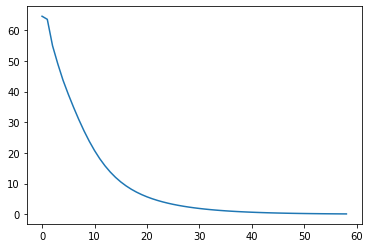

In [0]:
# print(state_value[0,0])
max_iters = 120
iter = 0
vs_prev = state_value
error = 1E5
convergence = []
pi = np.zeros((len(actions),max_cars+1,max_cars+1))
pi[5,:,:] = 1
while iter < max_iters and error > 0.1:
  pi = improve_policy(vs_prev)
  vs_new = evaluate_policy(vs_prev,pi)
  # pi = improve_policy(vs_new)
  error = np.max(np.abs(vs_new-vs_prev))
  vs_prev = vs_new
  # print(iter,error)
  convergence.append(error)
  iter = iter+1
print('Number of Iterations:',iter)
print('Final Error:',error)
# print(np.round(vs_new,1))
plt.plot(list(range(len(convergence))),convergence)
plt.show()

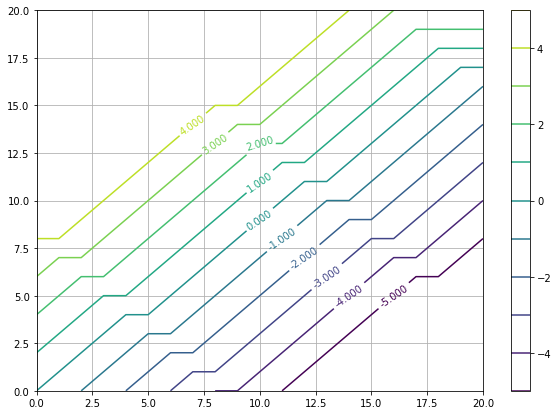

In [0]:
action_values = np.zeros((pi.shape[1],pi.shape[2]))
fig,ax = plt.subplots(1,1,figsize=(10,7))
for i in range(pi.shape[1]):
  for j in range(pi.shape[2]):
    ind = np.where(pi[:,i,j] == 1)[0]
    action_values[i,j] = ind[0]-5

# for a in range(4,7):#len(actions)):
#   pt = []
#   for j in range(pi.shape[2]):
#     for i in range(pi.shape[1]):
#       if pi[a,i,j] > 0:
#         if pt != []:
#           ax.plot([pt[0],i],[pt[1],j],'.')
#         pt = [i,j]
#         # print(pt)

#     # ax.plot([i,i-action_values[i,j]],[j,j+action_values[i,j]],'k')
# plt.show()


x = list(range(max_cars+1))
y = list(range(max_cars+1))
X,Y = np.meshgrid(x,y)

# fig,ax = plt.subplots(1,1,figsize=(10,7))
cp = ax.contour(X, Y, action_values,levels=actions)
ax.clabel(cp, inline=True, fontsize=10)
# ax.set_title('Contour Plot')
# ax.set_xlabel('x (cm)')
# ax.set_ylabel('y (cm)')
ax.grid(True)
plt.colorbar(cp)
plt.show()

In [0]:
# print(vs_new[4,4])
# print(vs_new[3,5])
print(pi[:,11,2])

i = 11
j = 3
print(i,j,vs_new[i,j])
for a in range(5):
  new_i = i-a
  new_j = j+a
  print(new_i,new_j,vs_new[new_i,new_j])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
11 3 475.7522949811615
11 3 475.7522949811615
10 4 483.4146704079878
9 5 489.11527617488804
8 6 493.22594238396715
7 7 496.21363712942934


-60 50.0


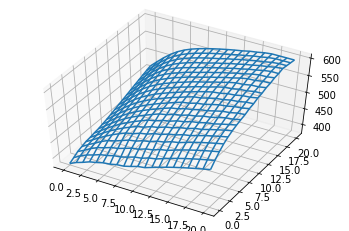

In [0]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# plt.plot3d(X,Y,vs_new)
ax.plot_wireframe(X, Y, vs_new)#, rstride=10, cstride=10)
ax.view_init(elev=50., azim=-60)
# azm=ax.azim
# ele=ax.elev
# print(azm,ele)

In [0]:
print(np.min(vs_new))
print(np.max(vs_new))

376.42857718358147
606.8964424150199
